In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from PIL import Image
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = {'Path': [], 'Class': []}

dataset_path = r'/kaggle/input/wound-classification/Wound_dataset copy'
entries = os.listdir(dataset_path)

for entry in entries:
    full_path = os.path.join(dataset_path, entry)
    if os.path.isdir(full_path):
        files = os.listdir(full_path)
        for file in files:
            file_path = os.path.join(full_path, file)
            
            data['Path'].append(os.path.join(entry, file))
            data['Class'].append(entry)

df = pd.DataFrame(data)

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Class')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number')
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('/kaggle/working/class-distribution.png')
plt.show()

In [4]:
dataloaders = ImageDataLoaders.from_df(df,
                                      path=dataset_path,
                                      fn_col='Path',
                                      label_col='Class',
                                      item_tfms=Resize(224),
                                      batch_tfms=aug_transforms())

In [7]:
epochs = [1, 2, 5, 10]
acc_s = []

for epoch in epochs:
    learn = vision_learner(dataloaders, resnet34, metrics=accuracy)
    learn.fine_tune(20 - epoch, freeze_epochs=epoch)

    interp = ClassificationInterpretation.from_learner(learn)
    acc = interp.confusion_matrix().diagonal().sum() / interp.confusion_matrix().sum()
    acc_s.append(acc)

epoch,train_loss,valid_loss,accuracy,time
0,2.390406,1.158289,0.658163,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.229346,0.860788,0.731293,00:16
1,0.965148,0.610798,0.829932,00:16
2,0.719169,0.466449,0.875850,00:16
3,0.528150,0.371399,0.903061,00:16
4,0.387460,0.317242,0.925170,00:16
5,0.294784,0.318157,0.935374,00:16
6,0.223825,0.236862,0.942177,00:16
7,0.163595,0.245673,0.947279,00:16
8,0.129772,0.246981,0.950680,00:15
9,0.099450,0.212507,0.962585,00:16


epoch,train_loss,valid_loss,accuracy,time
0,2.738489,1.313006,0.598639,00:13
1,1.829514,0.925845,0.736395,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.923826,0.686252,0.806122,00:16
1,0.727690,0.510385,0.855442,00:16
2,0.550291,0.378617,0.908163,00:16
3,0.418832,0.336843,0.928571,00:16
4,0.324994,0.327340,0.933673,00:16
5,0.238245,0.294540,0.937075,00:16
6,0.193659,0.306087,0.940476,00:16
7,0.149032,0.306823,0.940476,00:16
8,0.129198,0.343849,0.948980,00:16
9,0.099887,0.301364,0.957483,00:16


epoch,train_loss,valid_loss,accuracy,time
0,3.088968,1.807481,0.413265,00:13
1,2.274734,1.159244,0.653061,00:13
2,1.699938,0.872545,0.731293,00:13
3,1.294088,0.727115,0.780612,00:13
4,1.023715,0.623424,0.797619,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.592560,0.493283,0.848639,00:16
1,0.491508,0.380414,0.904762,00:16
2,0.382862,0.325045,0.916667,00:16
3,0.293619,0.286835,0.938776,00:16
4,0.239095,0.262371,0.937075,00:16
5,0.179675,0.253159,0.937075,00:16
6,0.147139,0.231104,0.957483,00:16
7,0.109231,0.256755,0.950680,00:16
8,0.083036,0.201329,0.955782,00:16
9,0.059482,0.213943,0.960884,00:16


epoch,train_loss,valid_loss,accuracy,time
0,3.147990,1.994651,0.348639,00:13
1,2.534152,1.429880,0.549320,00:13
2,2.019854,1.056259,0.681973,00:13
3,1.611509,0.891120,0.727891,00:13
4,1.308780,0.792692,0.748299,00:13
5,1.093493,0.687739,0.797619,00:13
6,0.937765,0.592006,0.821429,00:13
7,0.792661,0.541991,0.850340,00:13
8,0.672384,0.524367,0.845238,00:13
9,0.586867,0.486837,0.855442,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.413828,0.401345,0.896259,00:16
1,0.330050,0.328686,0.918367,00:16
2,0.286273,0.324863,0.913265,00:16
3,0.226469,0.297375,0.926871,00:16
4,0.164081,0.278988,0.950680,00:16
5,0.121131,0.217684,0.959184,00:16
6,0.089004,0.232025,0.964286,00:16
7,0.069870,0.248290,0.957483,00:16
8,0.053515,0.253050,0.960884,00:16
9,0.040758,0.248636,0.959184,00:16


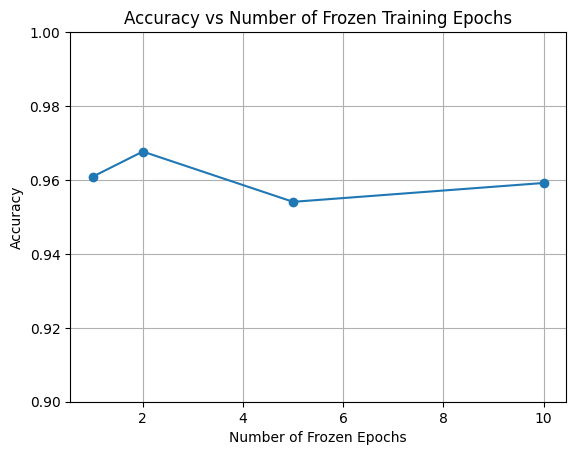

In [10]:
plt.plot(epochs, acc_s, marker='o')
plt.xlabel('Number of Frozen Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Frozen Training Epochs')
plt.ylim(0.9, 1)
plt.grid(True)
plt.savefig('/kaggle/working/Epochs-accuracy.png')
plt.show()

In [5]:
learn = vision_learner(dataloaders, resnet34, metrics=accuracy)
learn.fine_tune(20, freeze_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 219MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,3.167027,1.805804,0.413265,00:16
1,2.283088,1.175589,0.641156,00:12
2,1.700889,0.870317,0.734694,00:12
3,1.307409,0.706161,0.785714,00:12
4,1.018517,0.695930,0.780612,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.607188,0.519374,0.845238,00:16
1,0.481203,0.403267,0.892857,00:15
2,0.394557,0.347199,0.911565,00:16
3,0.300296,0.312502,0.926871,00:16
4,0.225558,0.336973,0.945578,00:16
5,0.186071,0.298108,0.935374,00:16
6,0.159955,0.297206,0.945578,00:16
7,0.134426,0.284997,0.957483,00:16
8,0.109740,0.263823,0.957483,00:15
9,0.094426,0.245844,0.962585,00:15


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.export('/kaggle/working/model.pkl')

In [ ]:
def get_preds(dl):
    inputs, targets, outputs = [], [], []
    for batch in dl:
        with torch.no_grad():
            preds = learn.model(batch[0])
            outputs.extend(preds.argmax(dim=1).cpu().numpy())
            targets.extend(batch[1].cpu().numpy())
            inputs.extend(batch[0].cpu().numpy())
    return inputs, targets, outputs

# Get predictions for both training and validation sets
train_inputs, train_targets, train_outputs = get_preds(learn.dls.train)
val_inputs, val_targets, val_outputs = get_preds(learn.dls.valid)

# Combine predictions
all_targets = train_targets + val_targets
all_outputs = train_outputs + val_outputs

# Generate confusion matrix
cm = confusion_matrix(all_targets, all_outputs)
labels = learn.dls.vocab

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the size as needed

# Plot the heatmap on the created axes
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Save the figure
fig.savefig('/kaggle/working/confusion-matrix.png', dpi=300)  # Adjust dpi for higher resolution

# Show the plot
plt.show()